In [1]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.misc import euler_rule, qconj, q2rm, quat_prod
from varitop.integrator import DelIntegrator as DI
from varitop.opti import Varitop

In [3]:
import numpy as np
from time import sleep

In [4]:
%%capture
!pip3 install robot_descriptions
from robot_descriptions.skydio_x2_mj_description import MJCF_PATH
from robot_descriptions.skydio_x2_description import URDF_PATH

In [5]:
from mujoco_simulator.model_builder import ModelBuilder
from mujoco_simulator.simulator import MujocoRender

In [6]:
model_wrapper = ModelBuilder(MJCF_PATH)
model_wrapper.add_arena()
model_wrapper.build()
ren = MujocoRender(model=model_wrapper, 
                   start=True, 
                   convention='pin')
Q_INIT = np.array([0, 0, 1.0, 0, 0, 0,1])
ren.set_state(Q_INIT)

Process render is starting!


In [7]:
from darli.model import Functional
from darli.backend import CasadiBackend, JointType
from darli.backend.liecasadi.so3 import SO3
from darli.state_space import StateSpace
import casadi as cs

model = Functional(CasadiBackend(URDF_PATH))
# TODO: add selector
selector = np.array([[0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [1.0, 1.0, 1.0, 1.0],
                     [-0.18, 0.18, 0.18, -0.18],
                     [0.14, 0.14, -0.14, -0.14],
                     [-0.0201, 0.0201, 0.0201, -0.0201]])

model.update_selector(selector)

In [8]:
di = DI(
    nq = model.nq,
    nu = 4,
    free_body = True,
    selector = selector,
    lagrangian=model.lagrangian,
)

In [9]:
phi = cs.Function()

In [10]:
(di.q[3:].T @ di.q[3:]).shape

(1, 1)

In [11]:
di.add_constraint(di.q[3:].T @ di.q[3:] - 1)

In [12]:
vp = Varitop(integrator=di, nsteps=40)

In [13]:
tf = vp.parameter(1)
dt = tf / vp.ns
vp.dt = dt

In [14]:
q0 = vp.parameter(model.nq)
qf = vp.parameter(model.nq)

In [15]:
position_weight = vp.parameter(1)
acceleration_weight = vp.parameter(1)
velocity_weight = vp.parameter(1)
control_weight = vp.parameter(1)
control_max = vp.parameter(model.nu)

In [16]:
q = vp.q
u = vp.u
ns = vp.ns
dt = vp.dt

In [17]:
cost = 0 
for i in range(1, vp.ns):
    cost += position_weight*cs.sumsqr(q[:3,i] - qf[:3])*dt
    cost += control_weight*cs.sumsqr(u[:,i])*dt

In [18]:
for i in range(1, vp.ns):
    vp.bounded(np.zeros(model.nu), u[:, i], control_max)
    vp.subject_to(q[2, i] >= 0.4)
    
vp.set_initial_configuration(q0)
vp.set_terminal_configuration(qf)
# these make him spin, but find better sol
vp.subject_to(vp.q[:, 0] - vp.q[:, 1] == 0)
vp.subject_to(vp.q[:, -1] - vp.q[:, -2] == 0)

In [19]:
vp.set_cost(cost)

In [20]:
np.random.seed(42)

In [21]:
Q_INIT = np.array([0, 0, 1.5, 0,0,0, 1])
quat_random = np.random.rand(4)
quat_random /= np.linalg.norm(quat_random)
# quat_random = np.array([0, 0, 0, 1])
Q_INIT[3:] = quat_random
Q_FINAL = np.array([0, 0., 2.5, 0, 0, 0, 1])
Q_FINAL[:3] += np.random.randn(3)

t_final = 3

vp.set_parameter(tf, t_final)
vp.set_parameter(control_max, 50*np.ones(model.nu) )
vp.set_parameter(q0, Q_INIT)
vp.set_parameter(qf, Q_FINAL)

vp.set_parameter(position_weight[0], 5)
vp.set_parameter(velocity_weight[0], 10)
vp.set_parameter(acceleration_weight[0], 5)
vp.set_parameter(control_weight[0], 5)

vp.set_initial(q[3:,:], np.array([Q_INIT[3:]]*(vp.ns+1)).T)
vp.set_initial(q[:3,:], np.linspace(Q_INIT[:3], Q_FINAL[:3], vp.ns+1).T)

ren.set_state(Q_INIT)
ren.markers[vp.ns+1](position=Q_FINAL[:3],
                color=[1, 0, 0, 0.5],
                size=0.04)
ren.markers[vp.ns+2](position=Q_INIT[:3],
                color=[0, 1, 0, 0.5],
                size=0.04)


In [22]:

sol = vp.solve()
q_opt = vp.value(vp.q)
u_opt = vp.value(vp.u)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     6165
Number of nonzeros in inequality constraint Jacobian.:      195
Number of nonzeros in Lagrangian Hessian.............:     4179

Total number of variables............................:      487
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      340
Total number of inequality c

In [23]:
ns = vp.ns

In [24]:
ren.set_state(Q_INIT)

In [25]:
for i in range(ns+1):
    ren.set_state(q_opt[:, i])

    for j in range(i):
        ren.markers[j](position=q_opt[:3, j],
                       color=[0, 0, 1, 0.5],
                       size=j*0.02/ns + 0.01)

    ren.markers[ns+1](position=Q_FINAL[:3],
                      color=[1, 0, 0, 0.5],
                      size=0.04)
    ren.markers[ns+2](position=Q_INIT[:3],
                    color=[0, 1, 0, 0.5],
                    size=0.04)
    sleep(t_final/ns)

In [38]:
ts = np.linspace(0, t_final, ns)

In [39]:
import matplotlib.pyplot as plt

In [52]:
Q_FINAL

array([-0.23415337, -0.23413696,  4.07921282,  0.        ,  0.        ,
        0.        ,  1.        ])

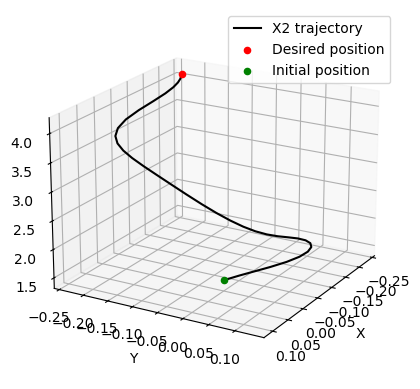

In [57]:
ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = q_opt[0, :]
y = q_opt[1, :]
z = q_opt[2, :]
ax.plot(x, y, z, label='X2 trajectory', color='black')
ax.scatter(Q_FINAL[0], Q_FINAL[1], Q_FINAL[2], color='red', label='Desired position')
ax.scatter(Q_INIT[0], Q_INIT[1], Q_INIT[2], color='green', label='Initial position')

# Make legend, set axes limits and labels
ax.legend()
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=30, roll=0)
plt.savefig('trajectory.png', dpi=300)
plt.show()

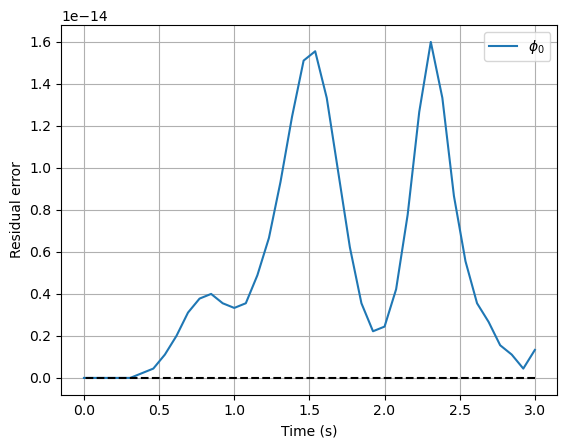

In [60]:
fig, ax = plt.subplots()

ax.plot(ts, np.linalg.norm(q_opt[3:7, 1:].T, axis=1) - 1, label='$\\phi_0$')
ax.hlines(0, 3, 0, color='black', linestyles='--')
ax.grid()
ax.set_ylabel('Residual error')
ax.set_xlabel('Time (s)')
ax.legend()
plt.savefig('constraint.png', dpi=300)
plt.show()

In [61]:
ws = []
for i in range(len(q_opt.T)):
    qi = q_opt[3:7, i]
    qj = q_opt[3:7, i - 1]
    dq = (qi - qj) * ns / t_final
    ws.append(di.q2w(qi, dq)[:3])
ws = np.array(ws).squeeze()

In [62]:
v = np.diff(q_opt[:3, :].T, axis=0)

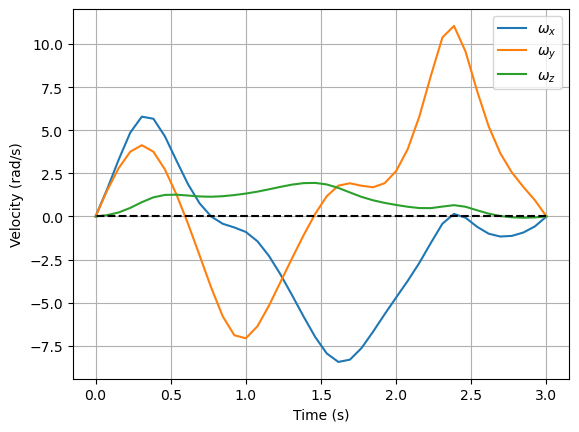

In [63]:
fig, ax = plt.subplots()

ax.plot(ts, ws[1:], label=['$\omega_x$', '$\omega_y$', '$\omega_z$'])
ax.hlines(0, 3, 0, color='black', linestyles='--')
ax.legend()
ax.grid()
ax.set_ylabel('Velocity (rad/s)')
ax.set_xlabel('Time (s)')
plt.savefig('angular_velocity.png', dpi=300)
plt.show()

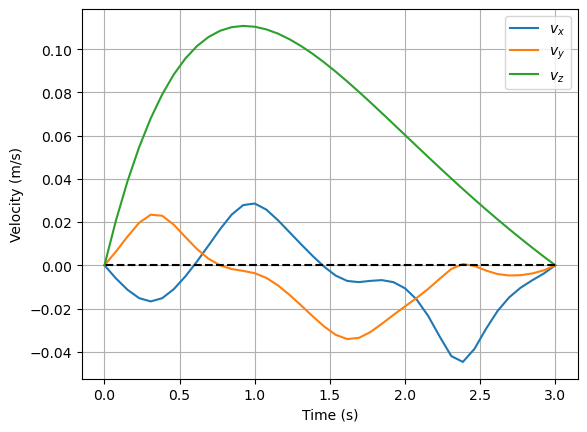

In [64]:
fig, ax = plt.subplots()

ax.plot(ts, v, label=['$v_x$', '$v_y$', '$v_z$'])
ax.hlines(0, 3, 0, color='black', linestyles='--')
ax.legend()
ax.grid()
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
plt.savefig('linear_velocity.png', dpi=300)
plt.show()